In [ ]:

import sys
import os
sys.path.append(os.path.abspath('src'))
import requests
from dotenv import load_dotenv
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
from src.data.fetch_data import fetch_eia_hourly_demand, fetch_weather_data
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import pacf, acf
load_dotenv()

EIA_KEY = os.getenv("EIA_KEY")

NameError: name 'os' is not defined

In [ ]:
# Run cell if you need Energy Data

df_EIA_Demand = fetch_eia_hourly_demand(
    api_key=EIA_KEY,
    start_date="2022-01-01T00",
    end_date="2024-12-31T00"
)

df_EIA_Demand


In [ ]:
# Run cell if you need Weather Data
weather_df = fetch_weather_data(
    latitude=29.7601,
    longitude=-95.3701,  # Houston
    start_date="2022-01-01",
    end_date="2024-12-31"
)

weather_df

Coordinates 29.75°N 95.5°E
Elevation 3867.0 m asl
Timezone NoneNone
Timezone difference to GMT+0 0 s


,date,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m
0,2022-01-01 00:00:00+00:00,-14.9355,81.0,-19.768436,0.0,0.0,0.0,7.0,7.704336
1,2022-01-01 01:00:00+00:00,-14.8855,69.0,-19.736115,0.0,0.0,0.0,7.0,7.289445
2,2022-01-01 02:00:00+00:00,-11.5355,60.0,-16.392967,0.0,0.0,0.0,7.0,7.787991
3,2022-01-01 03:00:00+00:00,-7.7855,51.0,-12.334994,0.0,0.0,0.0,7.0,6.193674
4,2022-01-01 04:00:00+00:00,-4.2855,43.0,-8.318744,0.0,0.0,0.0,7.0,3.075841


In [ ]:
# Uncomment if you dont already have data in your folder

# df_EIA_Demand.to_csv("./data/raw/EIA_Demand.csv", index=False)
# hourly_dataframe.to_csv("./data/raw/open_meteo.csv", index=False)

df_EIA_Demand = pd.read_csv('./data/raw/EIA_Demand.csv')
weather_df = pd.read_csv('./data/raw/openmeteo.csv')

In [332]:
df_EIA_Demand

,period,respondent,respondent-name,type,type-name,value,value-units
0,2024-12-31T00,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50098,megawatthours
1,2024-12-30T23,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50334,megawatthours
2,2024-12-30T22,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,50245,megawatthours
3,2024-12-30T21,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,49602,megawatthours
4,2024-12-30T20,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,48595,megawatthours
...,...,...,...,...,...,...,...
26276,2022-01-01T04,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,42058,megawatthours
26277,2022-01-01T03,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,43430,megawatthours
26278,2022-01-01T02,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,45058,megawatthours
26279,2022-01-01T01,ERCO,"Electric Reliability Council of Texas, Inc.",D,Demand,46427,megawatthours


In [ ]:
weather_df

,date,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m
0,2022-01-01 00:00:00+00:00,-14.9355,81.0,-19.768436,0.0,0.0,0.0,7.0,7.704336
1,2022-01-01 01:00:00+00:00,-14.8855,69.0,-19.736115,0.0,0.0,0.0,7.0,7.289445
2,2022-01-01 02:00:00+00:00,-11.5355,60.0,-16.392967,0.0,0.0,0.0,7.0,7.787991
3,2022-01-01 03:00:00+00:00,-7.7855,51.0,-12.334994,0.0,0.0,0.0,7.0,6.193674
4,2022-01-01 04:00:00+00:00,-4.2855,43.0,-8.318744,0.0,0.0,0.0,7.0,3.075841
...,...,...,...,...,...,...,...,...,...
26299,2024-12-31 19:00:00+00:00,-6.3590,56.0,-11.373190,0.0,0.0,0.0,0.0,10.315115
26300,2024-12-31 20:00:00+00:00,-6.6090,51.0,-11.878618,0.0,0.0,0.0,0.0,11.525623
26301,2024-12-31 21:00:00+00:00,-6.7590,50.0,-12.101495,0.0,0.0,0.0,0.0,11.885453
26302,2024-12-31 22:00:00+00:00,-7.0590,49.0,-12.459399,0.0,0.0,0.0,0.0,12.096214


In [333]:
EIA_clean_df = df_EIA_Demand.drop(axis=0, columns={'respondent-name', 'type', 'value-units', 'respondent', 'type-name'})

In [290]:
EIA_clean_df.rename(columns={'value':'demand-mwh'}, inplace=True)
EIA_clean_df

,period,demand-mwh
0,2024-12-31T00,50098
1,2024-12-30T23,50334
2,2024-12-30T22,50245
3,2024-12-30T21,49602
4,2024-12-30T20,48595
...,...,...
26276,2022-01-01T04,42058
26277,2022-01-01T03,43430
26278,2022-01-01T02,45058
26279,2022-01-01T01,46427


In [291]:
EIA_clean_df['period'] = pd.to_datetime(EIA_clean_df['period'],utc=True )
EIA_clean_df = EIA_clean_df.set_index('period').sort_index()


In [292]:
EIA_clean_df['demand-mwh'] = pd.to_numeric(EIA_clean_df['demand-mwh'], errors='coerce')

In [301]:
weather_df['date'] = pd.to_datetime(weather_df['date'],utc=True )
weather_df = weather_df.set_index('date').sort_index()

In [303]:

merged_df = pd.merge(EIA_clean_df, weather_df, left_index=True, right_index=True, how='inner')
merged_df

,demand-mwh,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m
2022-01-01 00:00:00+00:00,45943,-14.9355,81.0,-19.768436,0.0,0.0,0.0,7.0,7.704336
2022-01-01 01:00:00+00:00,46427,-14.8855,69.0,-19.736115,0.0,0.0,0.0,7.0,7.289445
2022-01-01 02:00:00+00:00,45058,-11.5355,60.0,-16.392967,0.0,0.0,0.0,7.0,7.787991
2022-01-01 03:00:00+00:00,43430,-7.7855,51.0,-12.334994,0.0,0.0,0.0,7.0,6.193674
2022-01-01 04:00:00+00:00,42058,-4.2855,43.0,-8.318744,0.0,0.0,0.0,7.0,3.075841
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,48595,-5.9090,64.0,-10.360739,0.0,0.0,0.0,10.0,7.386582
2024-12-30 21:00:00+00:00,49602,-6.0590,65.0,-10.660102,0.0,0.0,0.0,10.0,8.435069
2024-12-30 22:00:00+00:00,50245,-6.4090,65.0,-11.033361,0.0,0.0,0.0,0.0,8.435069
2024-12-30 23:00:00+00:00,50334,-6.6590,63.0,-11.433847,0.0,0.0,0.0,0.0,9.178235


In [305]:
merged_df.interpolate()

,demand-mwh,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m
2022-01-01 00:00:00+00:00,45943,-14.9355,81.0,-19.768436,0.0,0.0,0.0,7.0,7.704336
2022-01-01 01:00:00+00:00,46427,-14.8855,69.0,-19.736115,0.0,0.0,0.0,7.0,7.289445
2022-01-01 02:00:00+00:00,45058,-11.5355,60.0,-16.392967,0.0,0.0,0.0,7.0,7.787991
2022-01-01 03:00:00+00:00,43430,-7.7855,51.0,-12.334994,0.0,0.0,0.0,7.0,6.193674
2022-01-01 04:00:00+00:00,42058,-4.2855,43.0,-8.318744,0.0,0.0,0.0,7.0,3.075841
...,...,...,...,...,...,...,...,...,...
2024-12-30 20:00:00+00:00,48595,-5.9090,64.0,-10.360739,0.0,0.0,0.0,10.0,7.386582
2024-12-30 21:00:00+00:00,49602,-6.0590,65.0,-10.660102,0.0,0.0,0.0,10.0,8.435069
2024-12-30 22:00:00+00:00,50245,-6.4090,65.0,-11.033361,0.0,0.0,0.0,0.0,8.435069
2024-12-30 23:00:00+00:00,50334,-6.6590,63.0,-11.433847,0.0,0.0,0.0,0.0,9.178235


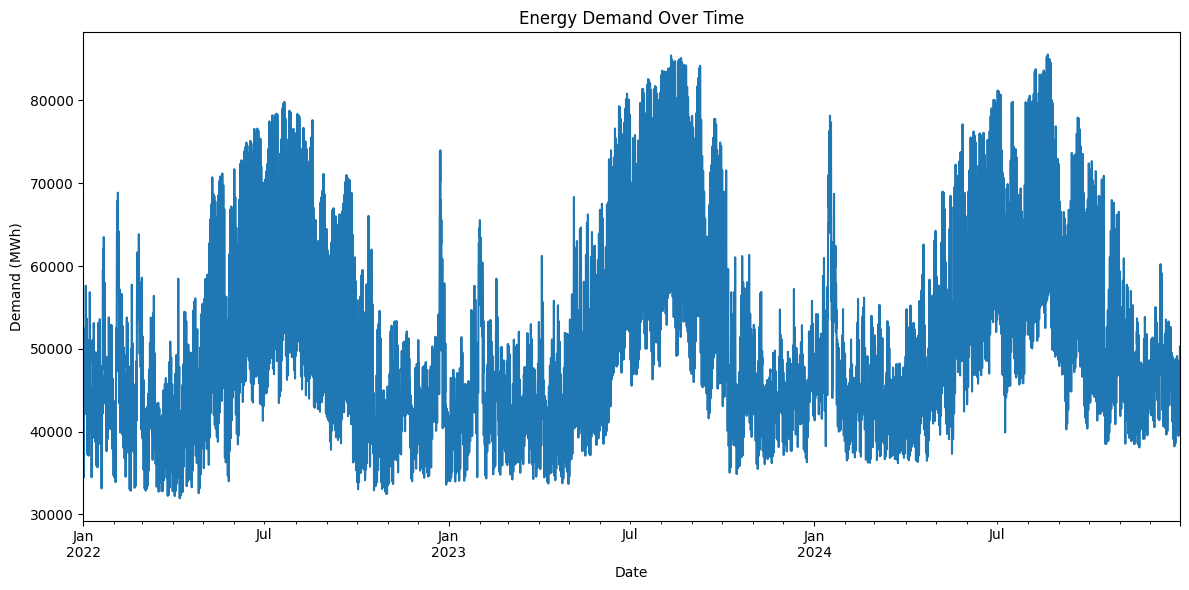

In [293]:
plt.figure(figsize=(12, 6))
EIA_clean_df['demand-mwh'].plot(title='Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')
plt.tight_layout()
plt.show()

In [294]:
daily_demand = EIA_clean_df.resample('D').sum()
daily_demand

,demand-mwh
period,
2022-01-01 00:00:00+00:00,962917
2022-01-02 00:00:00+00:00,1116780
2022-01-03 00:00:00+00:00,1197907
2022-01-04 00:00:00+00:00,1116957
2022-01-05 00:00:00+00:00,1000269
...,...
2024-12-27 00:00:00+00:00,1094937
2024-12-28 00:00:00+00:00,1083502
2024-12-29 00:00:00+00:00,1045355


In [304]:
merged_df.describe()


,demand-mwh,temperature_2m,relative_humidity_2m,apparent_temperature,rain,showers,snowfall,cloud_cover,wind_speed_10m
count,26281.000000,26281.000000,26281.000000,26281.000000,26281.000000,26281.000000,26281.000000,26281.000000,26281.000000
mean,50993.308892,1.970147,82.905029,-1.074338,0.123709,0.053107,0.068301,80.204292,7.716338
std,11033.392988,6.296857,19.581806,7.460186,0.420054,0.174362,0.212505,34.387444,4.228854
min,31949.000000,-27.935501,8.000000,-33.361145,0.000000,0.000000,0.000000,0.000000,0.000000
25%,43011.000000,-2.785500,75.000000,-6.861598,0.000000,0.000000,0.000000,80.000000,4.693825
50%,48036.000000,1.841000,91.000000,-1.335941,0.000000,0.000000,0.000000,100.000000,6.915374
75%,56994.000000,7.114500,97.000000,5.156981,0.000000,0.000000,0.000000,100.000000,9.957108
max,85544.000000,22.864500,100.000000,23.433313,7.100000,4.600000,3.010000,101.000000,41.548428


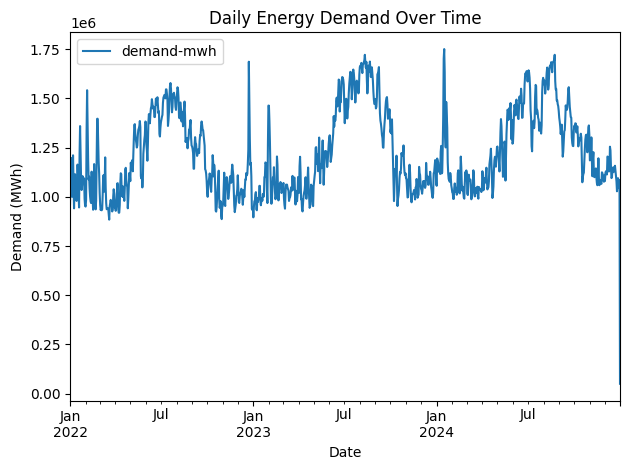

In [295]:
daily_demand.plot(title='Daily Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')
plt.tight_layout()
plt.show()

<Axes: title={'center': 'Weekly Energy Demand Over Time'}, xlabel='Date', ylabel='Demand (MWh)'>

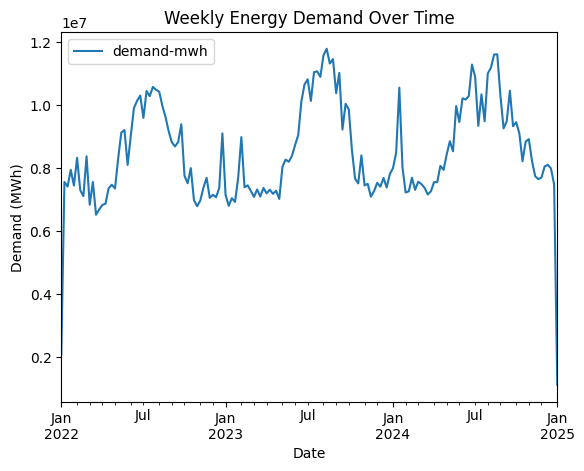

In [296]:
weekly_demand = EIA_clean_df.resample('W').sum()
weekly_demand.plot(title='Weekly Energy Demand Over Time', xlabel='Date', ylabel='Demand (MWh)')


In [309]:
merged_df.index = merged_df.index.tz_convert('America/Chicago') 

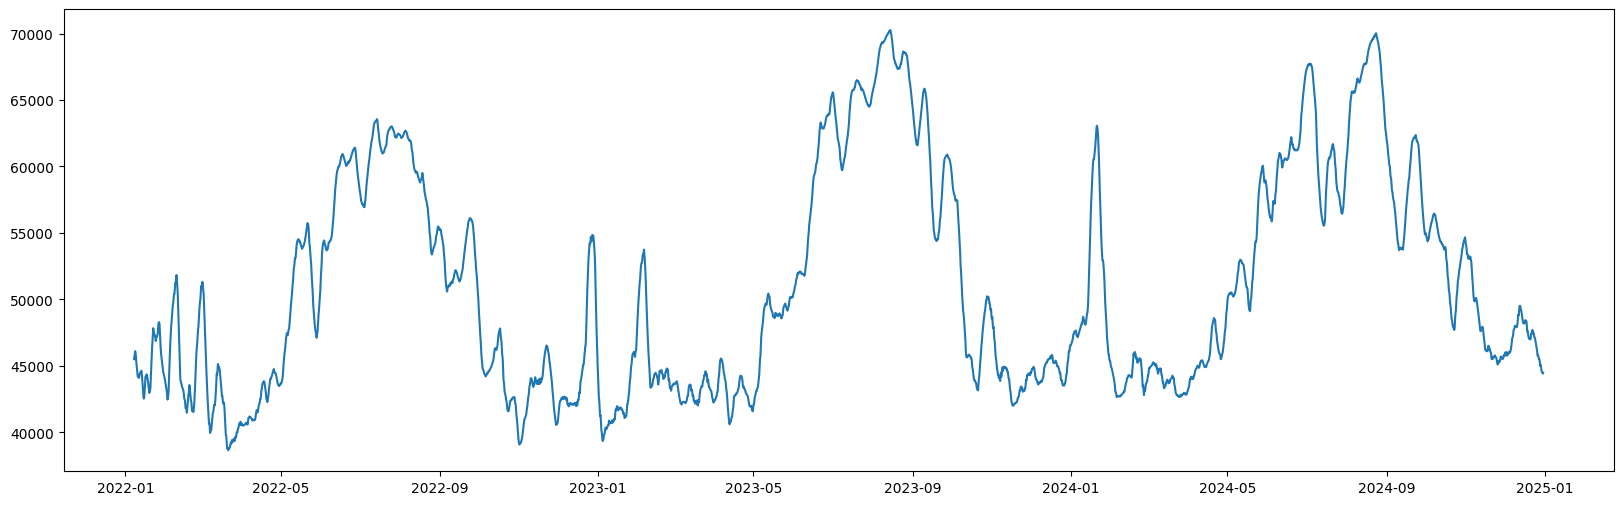

In [340]:
rolling3d_demand = merged_df['demand-mwh'].rolling(window=168).mean()
plt.figure(figsize=(20, 6))
plt.plot(rolling3d_demand)

we see a increase in demand during the summer months

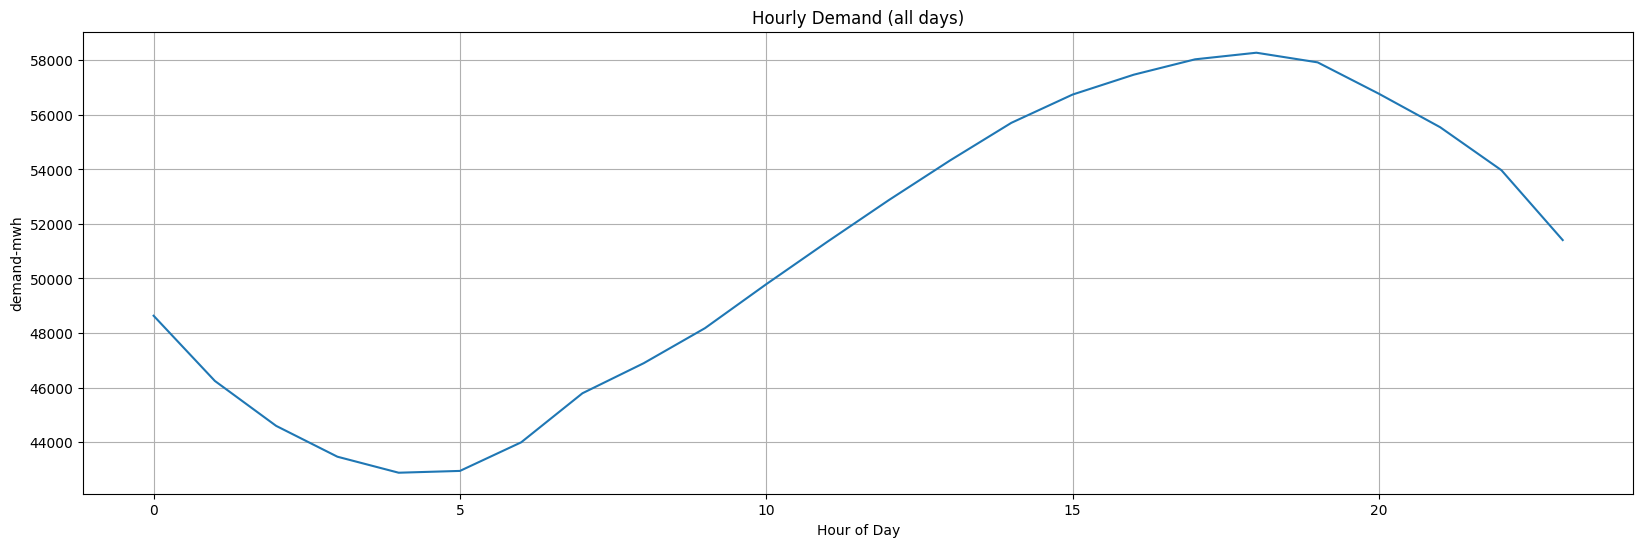

In [310]:
merged_df['hour'] = merged_df.index.hour
merged_df['day'] = merged_df.index.weekday + 1
fig, ax = plt.subplots(figsize=(20,6))

hourly_avg = merged_df.groupby('hour')['demand-mwh'].mean()
hourly_avg.plot(title='Hourly Demand (all days)')
plt.xlabel('Hour of Day')
plt.ylabel('demand-mwh')
plt.grid()
plt.show()

this confirms that there is a daily cycle

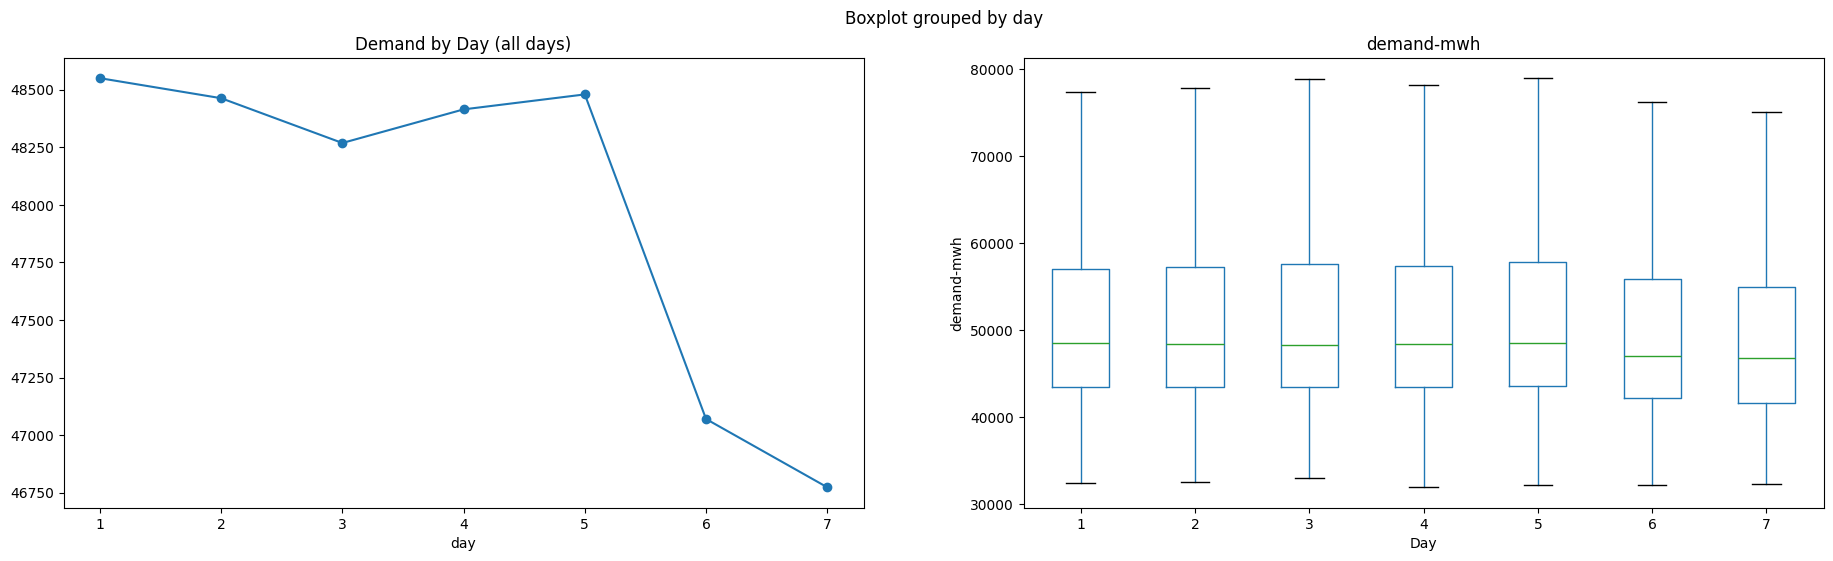

In [311]:
hourly_avg = merged_df.groupby('day')['demand-mwh'].median()

fig, ax = plt.subplots(1,2,figsize=(22,6))
hourly_avg.plot(title='Demand by Day (all days)',ax=ax[0], style='o-')
merged_df.boxplot(column='demand-mwh', by='day', ax=ax[1],showfliers=False)
plt.xlabel('Day')
plt.ylabel('demand-mwh')
plt.grid()
plt.show()

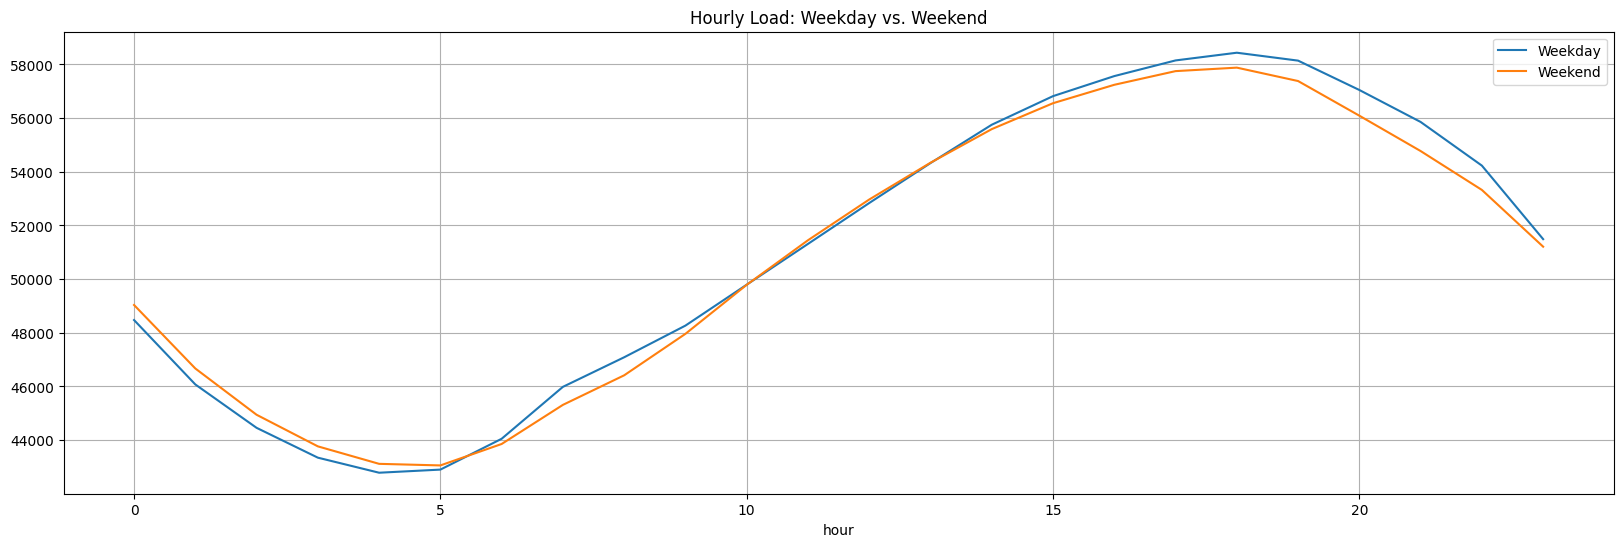

In [312]:
merged_df['is_weekend'] = merged_df['day'].isin([5, 6])  # 5=Saturday, 6=Sunday

weekday_hourly = merged_df[~merged_df['is_weekend']].groupby('hour')['demand-mwh'].mean()
weekend_hourly = merged_df[merged_df['is_weekend']].groupby('hour')['demand-mwh'].mean()

plt.figure(figsize=(20, 6))
weekday_hourly.plot(label='Weekday')
weekend_hourly.plot(label='Weekend')
plt.title('Hourly Load: Weekday vs. Weekend')
plt.legend()
plt.grid()
plt.show()

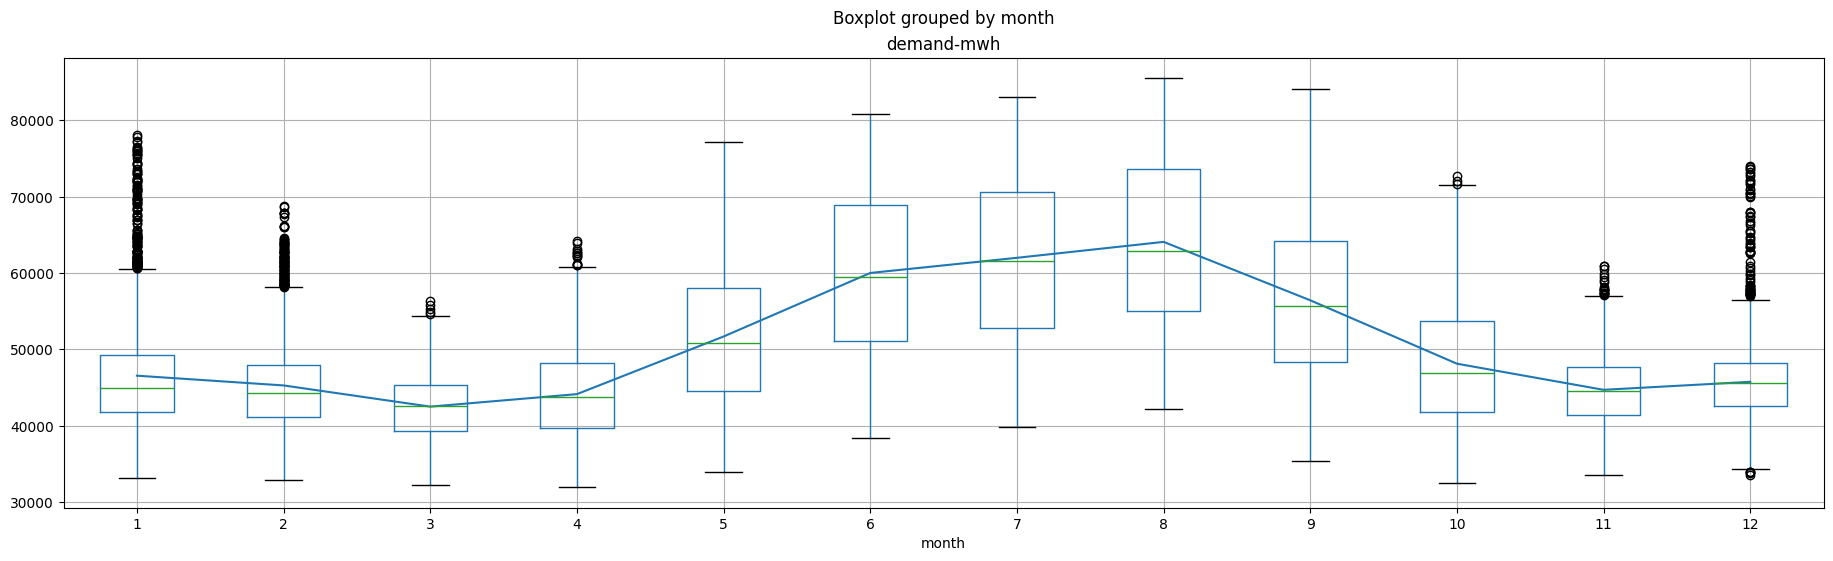

In [313]:
fig, ax =plt.subplots(figsize= (22,6))


merged_df['month'] = merged_df.index.month
monthly_avg = merged_df.groupby('month')['demand-mwh'].mean()

merged_df.boxplot(column='demand-mwh', by = 'month', ax=ax)
monthly_avg.plot(label='Month', ax=ax)
plt.grid()
plt.show()




demand peaks in the summer

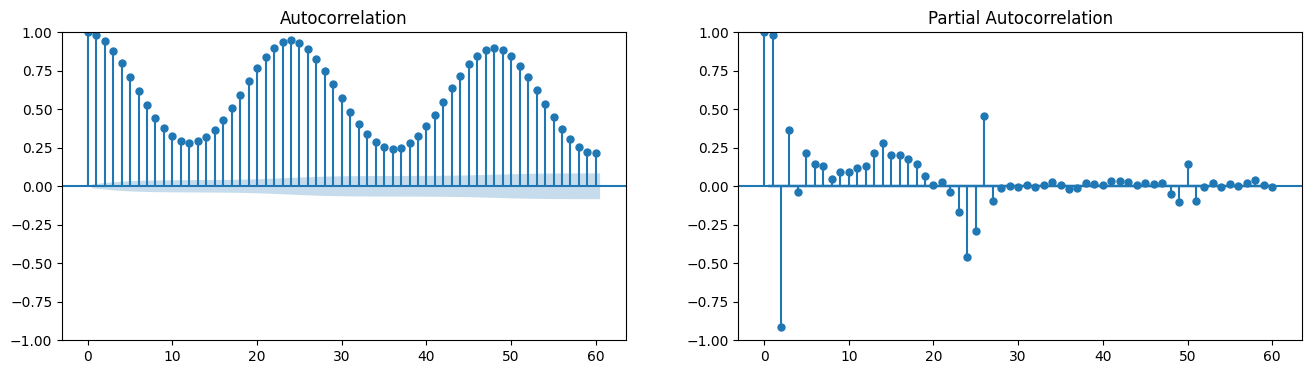

In [315]:
fig, ax = plt.subplots(1,2,figsize=(16, 4))
plot_acf(merged_df['demand-mwh'], ax=ax[0], lags=60)
plot_pacf(merged_df['demand-mwh'], ax=ax[1], lags=60, alpha=.05)
plt.show()

In [337]:
# Calculate autocorrelation and partial autocorrelation
n_lags = 60
pacf_values = pacf(merged_df['demand-mwh'], nlags=n_lags, method='ols')  # Partial ACF
acf_values = acf(merged_df['demand-mwh'], nlags=n_lags, fft=False)       # ACF

# Create DataFrame
corr_table = pd.DataFrame({
    'lag': range(n_lags + 1),
    'partial_autocorrelation': pacf_values,
    'partial_autocorrelation_abs': np.abs(pacf_values),
    'autocorrelation': acf_values,
    'autocorrelation_abs': np.abs(acf_values)
})

# Sort by absolute partial autocorrelation (descending) and get top 10
top_lags = corr_table.sort_values('partial_autocorrelation_abs', ascending=False).head(10)

top_lags

,lag,partial_autocorrelation,partial_autocorrelation_abs,autocorrelation,autocorrelation_abs
0,0,1.000000,1.000000,1.000000,1.000000
1,1,0.985064,0.985064,0.985063,0.985063
2,2,-0.916729,0.916729,0.943176,0.943176
24,24,-0.463085,0.463085,0.948977,0.948977
26,26,0.459744,0.459744,0.891203,0.891203
3,3,0.368608,0.368608,0.879523,0.879523
25,25,-0.292146,0.292146,0.932866,0.932866
14,14,0.280504,0.280504,0.319209,0.319209
5,5,0.218410,0.218410,0.709925,0.709925
13,13,0.215386,0.215386,0.290967,0.290967


In [1]:
merged_df

NameError: name 'merged_df' is not defined